A tutorial from [Jason Brownlee](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

The data is free and you can download from [here](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
data = pd.read_csv('international-airline-passengers.csv', usecols=[1],engine='python', skipfooter=3)
data.head(3)

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132


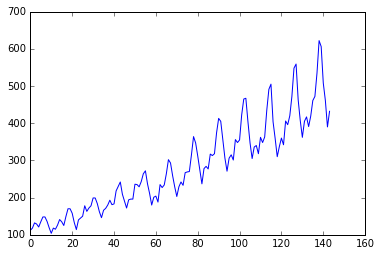

In [25]:
plt.plot(data)
plt.show()

In [17]:
# fix random seed for reproducity
np.random.seed(7)

In [18]:
# load the dataset
dataset = data.values

# convert integer values to floating point values, which are more suitable for modeling with a neural network
dataset = dataset.astype('float32')

In [70]:
# LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) ot tanh activation functions 
# are used. We will normalized the data with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
import math
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset[:5]

array([[ 0.01544401],
       [ 0.02702703],
       [ 0.05405405],
       [ 0.04826255],
       [ 0.03281853]], dtype=float32)

In [23]:
# split dataet into train and test sets

train_size = int(len(dataset)*0.67)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

print(len(train), len(test))

(96, 48)


In [47]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [48]:
# reshape into X = t and Y = t + 1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [80]:
scaler.inverse_transform(trainY)[0][:5]

array([ 0.02702703,  0.05405405,  0.04826255,  0.03281853,  0.05984557])

In [49]:
# LSTM network expects the input data (X) in the form of: [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [51]:
# create and fit the LSTM network

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

mdl = Sequential()
mdl.add(LSTM(4, input_dim = look_back))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Using Theano backend.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


Epoch 1/100
3s - loss: 0.0461
Epoch 2/100
3s - loss: 0.0227
Epoch 3/100
3s - loss: 0.0160
Epoch 4/100
3s - loss: 0.0143
Epoch 5/100
4s - loss: 0.0134
Epoch 6/100
3s - loss: 0.0126
Epoch 7/100
3s - loss: 0.0116
Epoch 8/100
3s - loss: 0.0106
Epoch 9/100
4s - loss: 0.0095
Epoch 10/100
3s - loss: 0.0083
Epoch 11/100
3s - loss: 0.0071
Epoch 12/100
3s - loss: 0.0059
Epoch 13/100
3s - loss: 0.0048
Epoch 14/100
3s - loss: 0.0039
Epoch 15/100
3s - loss: 0.0031
Epoch 16/100
3s - loss: 0.0026
Epoch 17/100
3s - loss: 0.0024
Epoch 18/100
3s - loss: 0.0022
Epoch 19/100
3s - loss: 0.0022
Epoch 20/100
4s - loss: 0.0021
Epoch 21/100
3s - loss: 0.0021
Epoch 22/100
3s - loss: 0.0021
Epoch 23/100
3s - loss: 0.0021
Epoch 24/100
3s - loss: 0.0021
Epoch 25/100
3s - loss: 0.0021
Epoch 26/100
3s - loss: 0.0021
Epoch 27/100
3s - loss: 0.0020
Epoch 28/100
3s - loss: 0.0020
Epoch 29/100
3s - loss: 0.0021
Epoch 30/100
3s - loss: 0.0021
Epoch 31/100
3s - loss: 0.0020
Epoch 32/100
3s - loss: 0.0020
Epoch 33/100
3s -

In [52]:
# make predictions
trainPred = mdl.predict(trainX)
testPred = mdl.predict(testX)
# invert predictions
trainPred = scaler.inverse_transform(trainPred)
testPred = scaler.inverse_transform(testPred)

trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [64]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.10 RMSE


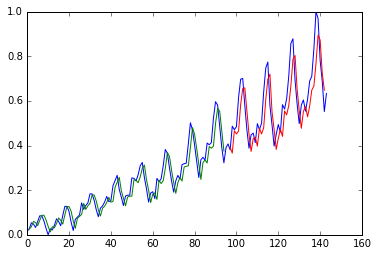

In [81]:
# shift tain prediction for plotting
trainPredPlot = np.empty_like(dataset)
trainPredPlot[:, :] = np.nan
trainPredPlot[look_back:len(trainPred)+look_back, :] = trainPred
#shift test prediction for plotting
testPredPlot = np.empty_like(dataset)
testPredPlot[:, :] = np.nan
testPredPlot[len(trainPred) + look_back*2 + 1:len(dataset)-1, :] = testPred

#plot baseline and predictions

plt.plot(dataset)
plt.plot(trainPredPlot)
plt.plot(testPredPlot)

plt.show()

In [3]:
from pandas import Series, DataFrame, Panel

date = pd.date_range('2015-01', '2018-01', freq='M')
date

DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', freq='M')

In [4]:
date.size

36

In [5]:
height = (1 + np.random.random(36))
height

array([ 1.70798883,  1.74584882,  1.11332857,  1.18925515,  1.12215182,
        1.96162421,  1.46061978,  1.99137025,  1.01903193,  1.94310333,
        1.00727743,  1.4747584 ,  1.05709503,  1.93567367,  1.28993108,
        1.64451389,  1.89492243,  1.05025133,  1.24004827,  1.83922679,
        1.28620447,  1.07445158,  1.5452026 ,  1.42638639,  1.65354773,
        1.11330084,  1.44195891,  1.51540603,  1.53682762,  1.36427157,
        1.73209165,  1.35258185,  1.82234557,  1.4127548 ,  1.25990417,
        1.46452146])

In [6]:
weight = np.round((1 + np.random.random(36)) * 100, 0)
weight

array([ 175.,  174.,  105.,  188.,  137.,  143.,  184.,  194.,  109.,
        141.,  117.,  111.,  174.,  170.,  159.,  188.,  105.,  140.,
        147.,  161.,  100.,  116.,  182.,  182.,  103.,  147.,  179.,
        105.,  101.,  159.,  122.,  157.,  160.,  169.,  123.,  106.])

In [7]:
data = pd.DataFrame({'date': Series(date), 'height':Series(height), 'weight':Series(weight)})
data.head()

,date,height,weight
0,2015-01-31,1.707989,175.0
1,2015-02-28,1.745849,174.0
2,2015-03-31,1.113329,105.0
3,2015-04-30,1.189255,188.0
4,2015-05-31,1.122152,137.0


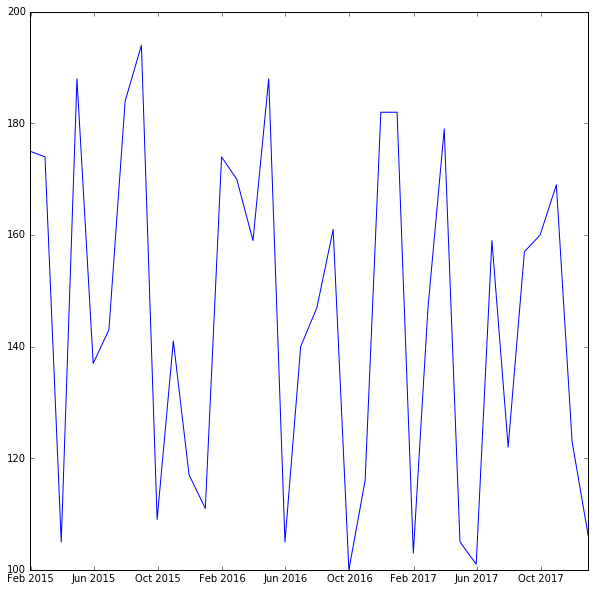

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

wt= Series(data.weight)
fig = plt.figure(figsize=(10,10))
plt.plot(date, wt, 'b-')
plt.show()